# Introduction

As we know, there are many different music genres in the world like pop, rock, R&B, latin, blues and etc. To satisfy the users' preferences for genre, most large music streaming service providers like **Spotify** have already built up a number of 
lists according to the genre of music. The following is what our project tries to solve:

* **`What features of the music can be used to classify its genre?`**
* **`Is it possible to auto-predict the genre accurately given these features?`**

In this project, our team is going to explore the relationship between music and its genre. In terms of music features, we focused on the following ones such as `acousticness`, `danceability`, `energy`, `instrumentalness` and the word frequency in the lyrics. We attempted many different machine learning models to explore which one performs the best regarding this particular problem. Also, we find that the model's accuracy decrease sharply when the number of music genre increase. In addition, all of the music data and lyrics are retrieved through the [Spotify web-api](https://beta.developer.spotify.com/documentation/web-api/) and [Musixmatch lyrics API](https://developer.musixmatch.com/documentation).

Our report is organized as follows:
* [Libraries](#1)
* [Musical Features Analysis](#2)
* [Lyrics Features Analysis](#3)
* [Modeling and Validation](#4)
  - [SVM](#4.1)
  - [Neural Network](#4.2)
  - [K-Nearest Neighbors](#4.3)
  - [Naive Bayes](#4.4)
  - [Random Forest](#4.5)
* [Modeling Optimization](#5)
  - [SVM](#5.1)
  - [Neural Network](#5.2)
  - [K-Nearest Neighbors](#5.3)
  - [Naive Bayes](#5.4)
  - [Random Forest](#5.5)
* [Summary](#6)
* [Appendix I: Data Collection](#7)
* [Appendix II: References](#8)

Are you excited to see how it works? Let's get started!

<a id = "1"></a>
# Libraries

In [57]:
# import necessary python packages
import requests
import io,time,json
import os
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import string
import sklearn
import re

from sklearn import svm
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.cross_validation import StratifiedShuffleSplit
from musixmatch import Musixmatch
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

<a id = "2"></a>
# Musical Features Analysis

In this section, we will try to use data visualization to unconver the potential relationship between features such as <b>`'acousticness'`, `'danceability'`</b> and music genres such as <b>`'classical'`, `'rock'`</b>. Then, we can try to draw a conclusion that which music genres are the most distinctive among these 10 genres. Next, we can first build machine learning models to classify the most distinctive genres. Finally, we will try to generalize these models to classify more genres.

### Main Ideas:
1. We use boxplot to compare music features such as danceability among these 10 genres.
2. We can then analyze these boxplots in order to identify the most distinctive features.
3. We can select these distinctive features to build our machine learning models to classify music genres.

In [42]:
# first we read music data from csv file into data frame
df_data = pd.read_csv("alldata_with_lyrics.csv", encoding="ISO-8859-1")
col_name = df_data.columns[0]
df_data = df_data.drop(columns=col_name)
df_data.head()

,acousticness,analysis_url,artists,danceability,duration_ms,energy,id,instrumentalness,key,liveness,...,tempo,time_signature,trackName,track_href,type,uri,valence,category,label,lyrics
0,0.003620,https://api.spotify.com/v1/audio-analysis/4ARe...,NOAX,0.541,140842,0.961,4AReuskFZseMj4RpJk0Zyi,0.578000,1,0.1090,...,75.005,4,The End,https://api.spotify.com/v1/tracks/4AReuskFZseM...,audio_features,spotify:track:4AReuskFZseMj4RpJk0Zyi,0.276,workout,0,NaN
1,0.007780,https://api.spotify.com/v1/audio-analysis/65ES...,Skrillex & Kendrick Lamar,0.898,156800,0.935,65ES1qwOB577ZnTkizMXJJ,0.000036,11,0.2170,...,150.016,4,HUMBLE. - SKRILLEX REMIX,https://api.spotify.com/v1/tracks/65ES1qwOB577...,audio_features,spotify:track:65ES1qwOB577ZnTkizMXJJ,0.884,workout,0,"Ayy, I remember syrup sandwiches and crime all..."
2,0.004990,https://api.spotify.com/v1/audio-analysis/74ip...,Onderkoffer,0.642,212804,0.848,74ipYItMMW9NRBhVBXrM6Q,0.051600,5,0.2390,...,150.121,4,Beast,https://api.spotify.com/v1/tracks/74ipYItMMW9N...,audio_features,spotify:track:74ipYItMMW9NRBhVBXrM6Q,0.142,workout,0,NaN
3,0.012900,https://api.spotify.com/v1/audio-analysis/4yfd...,G-Eazy & A$AP Rocky & French Montana & Juicy J...,0.840,278105,0.736,4yfdnCOjuDwf2Ivpo8vg8H,0.000000,1,0.0849,...,176.051,4,No Limit REMIX,https://api.spotify.com/v1/tracks/4yfdnCOjuDwf...,audio_features,spotify:track:4yfdnCOjuDwf2Ivpo8vg8H,0.415,workout,0,"If I hit it one time, I'ma pipe her\nIf I hit ..."
4,0.000956,https://api.spotify.com/v1/audio-analysis/1ivu...,Yellow Claw,0.829,211777,0.695,1ivuWgxFQb2xzxVNSlB1hF,0.178000,1,0.1120,...,102.018,4,DJ Turn It Up,https://api.spotify.com/v1/tracks/1ivuWgxFQb2x...,audio_features,spotify:track:1ivuWgxFQb2xzxVNSlB1hF,0.369,workout,0,Tell the Dj Turn It Up\nTell the Dj bring it b...


In [13]:
# get the column names
col_names = df_data.columns
col_needed = ['acousticness', 'category', 'danceability', 
              'duration_ms', 'energy', 'instrumentalness', 
              'key', 'liveness', 'loudness', 'speechiness', 
              'tempo', 'valence', 'lable']
# only select the necessary column names
df_data = df_data.loc[:,col_needed]
df_data.head()

,acousticness,category,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,lable
0,0.003620,workout,0.541,140842,0.961,0.578000,1,0.1090,-7.766,0.0773,75.005,0.276,NaN
1,0.007780,workout,0.898,156800,0.935,0.000036,11,0.2170,-2.744,0.2910,150.016,0.884,NaN
2,0.004990,workout,0.642,212804,0.848,0.051600,5,0.2390,-4.890,0.1150,150.121,0.142,NaN
3,0.012900,workout,0.840,278105,0.736,0.000000,1,0.0849,-3.757,0.2890,176.051,0.415,NaN
4,0.000956,workout,0.829,211777,0.695,0.178000,1,0.1120,-5.561,0.0473,102.018,0.369,NaN


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

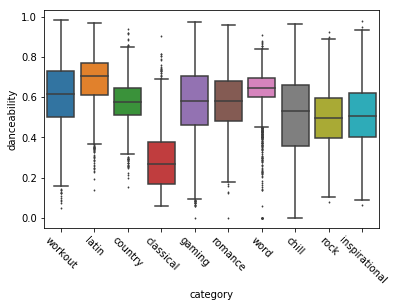

In [14]:
# Data Exploration And Visualization 
# how many categories are in the datasets
categories = np.unique(df_data.category)
n_categories = len(categories)

# danceability between different categories
data = pd.concat([df_data.danceability, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'danceability', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

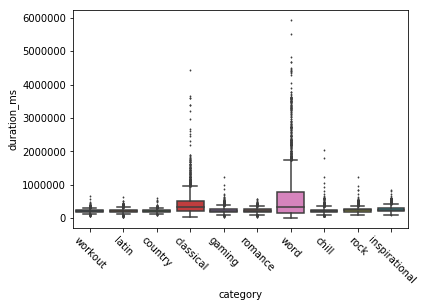

In [15]:
# duration_ms between different categories
# as we can see, the classical and word categories have extreme long duration_ms time
data = pd.concat([df_data.duration_ms, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'duration_ms', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(0, 1000000)

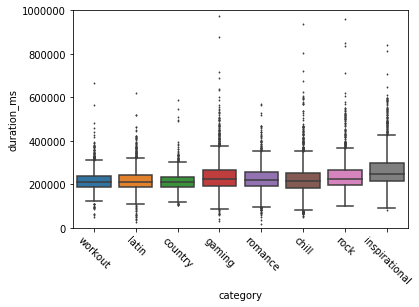

In [16]:
# duration_ms between different categories without word and classical
# as we can see, the duration_ms time for the rest of the categories are pretty much the same
data = df_data.loc[(df_data.category != 'word') & (df_data.category != 'classical'), :]
data = pd.concat([data.duration_ms, data.category, data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'duration_ms', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)
plt.ylim(0, 1000000)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

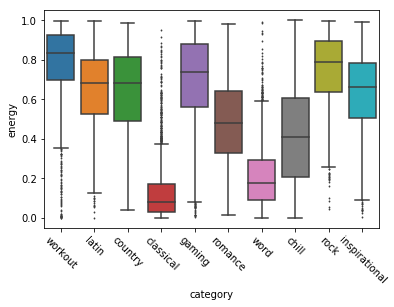

In [17]:
# energy between different categories
# as we can see, discrepancy of the energy level from different categories are quite obvious
data = pd.concat([df_data.energy, df_data.category, df_data.lable], axis = 1)
# ax = sns.boxplot(x = 'category', y = 'energy', data=data, showfliers = False)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'energy', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

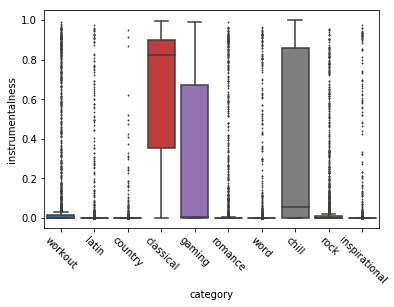

In [18]:
# instrumentalness between different categories
data = pd.concat([df_data.instrumentalness, df_data.category, df_data.lable], axis = 1)
# ax = sns.boxplot(x = 'category', y = 'instrumentalness', data=data, showfliers = False)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'instrumentalness', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

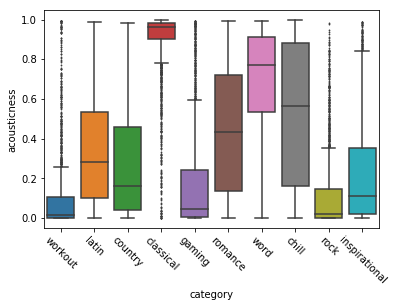

In [19]:
# acousticness between different categories
# as we can see, acousticness between different categories are quite different
data = pd.concat([df_data.acousticness, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'acousticness', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

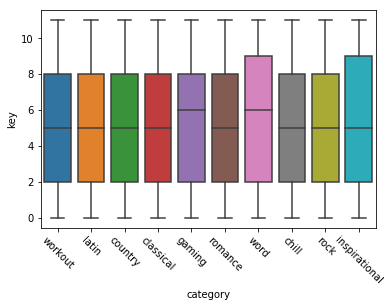

In [20]:
# key between different categories
# as we can see, key between different categories are not that different
data = pd.concat([df_data.key, df_data.category, df_data.lable], axis = 1)
ax = sns.boxplot(x = 'category', y = 'key', data=data)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

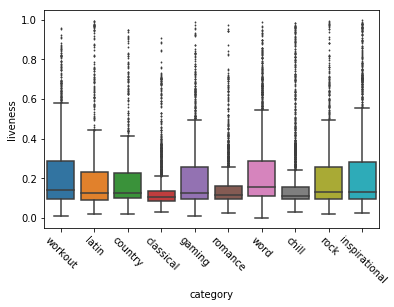

In [21]:
# liveness between different categories
# as we can see, key between different categories are not that different
data = pd.concat([df_data.liveness, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'liveness', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

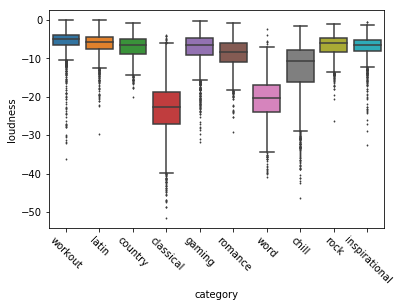

In [22]:
# loudness between different categories
# as we can see, loudness between different categories are not that obvious
# especially between categories workout, country, latin, rock, inspirational, gaming
data = pd.concat([df_data.loudness, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'loudness', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

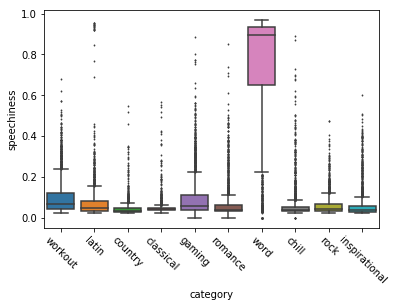

In [23]:
# speechiness between different categories
data = pd.concat([df_data.speechiness, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'speechiness', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

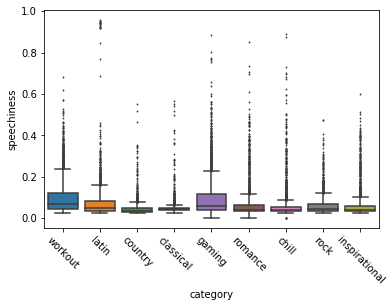

In [24]:
# speechiness between different categories without category word
data = df_data.loc[df_data.category != 'word', :]
data = pd.concat([data.speechiness, data.category, data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'speechiness', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

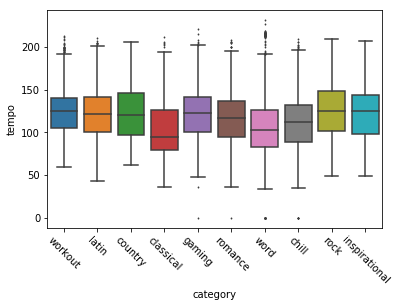

In [25]:
# tempo between different categories
# as you can see, the tempo is sort of different between categories
data = pd.concat([df_data.tempo, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'tempo', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

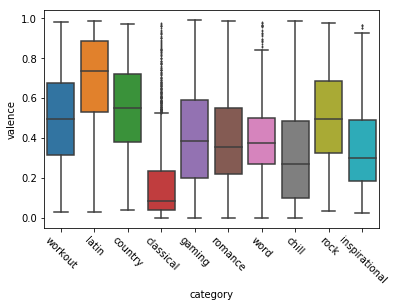

In [26]:
# valence between different categories
# as you can see, the valence is very different between categories
data = pd.concat([df_data.valence, df_data.category, df_data.lable], axis = 1)
# control the outlier's property (gray, and size)
flierprops = dict(markerfacecolor='0.5', markersize=1,
              linestyle='none')
ax = sns.boxplot(x = 'category', y = 'valence', data=data, flierprops=flierprops)
plt.xticks(rotation = -45)

From above analysis, we can safely conclude that features such as **speechiness**, **key**, **duration_ms**, **instrumentalness** might not be the most representative features to choose. However, based on features such as acousticness, energy, we can see that the following genres, word, workout, classical are the most distinctive among 10 genres. We can use this findings in the modeling and validation section.

<a id = "3"></a>
# Lyrics Features Analysis
In this section, we will explore the possiblity of extract feature out of the lyrics of songs. Lyrics of a song is an important feature to classify the category. After observering each category and their  lyrics, we found the pattern inside the lyrics are different. Some catogeries have a very distinctive lyrics. For example, for <b>`"Latin Music"`</b> Category, the lyrics are composed of all latin characters like <b>`'que'`, `'de'`, `'la'`, `'te'`</b>, etc. This differentiate themself from the common English songs.

Even though there are some common words like <b>`"love"`, `"baby"`, `"little"` </b>that appear in many categories, the fequency and popularity are totally different. In <b>`"Romance"`</b> category song, <b>`"love"`</b> and <b>`"like"`</b> nearly dominate the top word in lyrics and in <b>`"Workout"`</b> category, <b>`"love"`</b> also appears but obviously not that popular. 

### Main Ideas:

1. Extract all valid words from the entire lyrics training set and record the `frequency of each word`. A word is considered as valid when it is not a stopword and only contains a-z low case letters. We convert all word to the low case.

2. Remove the rare word like appears only once or twice among all the word set. In practice, we `exclude the words that appear less than 10`. This is a parameter that is proportional to the scale of the training set.

3. Based on the word set, we get a bag of words, and use each word's as a feature index. The actual value put here is the term frequency.



In [3]:
def process_lyrics(data_frame):
    """
    This function process the original dataframe and extract words from lyrics
    text, generate necessary data structure for next processing
    
    Args:
        data_frame (pandas dataframe) : the input dataframe
    Returns:
        (set) total_set : word set extracted from all songs' lyrics
        (dictionary) total_counter : word frequency from the songs' lyrics
        (set) song_set : all words in a song
        (dictionary) song_counter : all words counter in a song
        (dictionary) song_dict : track name to (song_set, song_counter) 
    """
    total_set = set()
    total_counter = Counter()
    song_dict = {}
    label_dict = {}
    for index, row in data_frame.iterrows():    
        lyrics_body = row['lyrics']
        track = row['trackName']
        label = row['category']
        if label not in label_dict.keys():
            label_dict.update({label : Counter()})
        label_counter = label_dict.get(label)
        song_set = set()
        song_counter = Counter()
        if lyrics_body != '':
            lyrics_body = lyrics_body[:lyrics_body.index('...')]
            sentence_list = lyrics_body.split('\n')
            for sentence in sentence_list:
                words = sentence.lower().split()
                for w in words:
                    song_counter[w] += 1
                    total_counter[w] += 1
                    label_counter[w] += 1
                    song_set.add(w)
            song_dict.update({track : (song_set, song_counter)})
            total_set = total_set.union(song_set)
    return (total_set, total_counter, song_dict, label_dict)

def drop_low_freq_words(total_set, total_counter, num, label_dict):
    """
    drop low frequent words and stopwords and non-words
    Args:
       total_set (set) : word set extracted from all songs' lyrics
       total_counter (dictionary) : word frequency from the songs' lyrics
       num (int) : drop words that frequency below num
       label_dict : label dictionary
    Returns:
       (list) : a list a sorted frequent words
    """
    word_pattern = re.compile("[a-z]*$")
    stopwords=nltk.corpus.stopwords.words('english')
    word_list = list(total_set)
    for word in word_list:
        if total_counter[word] < num or (not word_pattern.match(word)) or word in stopwords:
            total_set.remove(word)
            for label, counter in label_dict.items():
                if word in counter:
                    counter[word] = 0
                
    fword_list = list(total_set)
    return fword_list, label_dict

def plot_wordcloud_img(word_dict, title):
    """
    plot a word cloud image based on the given word dictionary and title
    Args:
       word_dict (dictionary) : word frequency from the songs' lyrics
       title (string) : drop words that frequency below num
    Returns:
       (plot) : wordcloud plot
    """
    word_cloud = WordCloud(max_font_size=60, width=200, height=200)
    word_cloud.generate_from_frequencies(word_dict)
    plt.figure()
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [29]:
df = df_data.dropna(axis=0)
a, b, c, category_dict = process_lyrics(df)
_, category_dict = drop_low_freq_words(a, b, 10, category_dict)
romance_dict = category_dict.get('romance')
latin_dict = category_dict.get('latin')

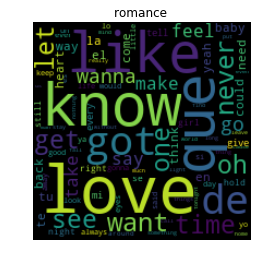

In [5]:
# Romance Lyrics Frequent Words
plot_wordcloud_img(romance_dict, 'romance ')

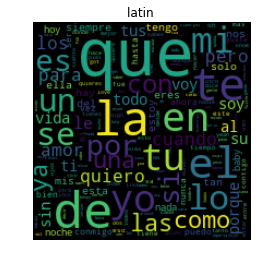

In [6]:
# Latin Lyrics Frequent Words
plot_wordcloud_img(latin_dict, 'latin ')

<a id = "4"></a>
# Modeling and Validation

In this section, we will use several machine learning models to train the processed data. Then, we will use test data sets to validate how these machine learning models perform. Finally, we can draw the conclusion which model gives us the best outcomes.

### Build a Four-Category Classifier

Based on the conclusion from data exploration and visualiztion section, we decided to first build a four-category classifier to predict the following genre, <b>`'word'`, `'workout'`, `'classifical'`, `'latin'`</b>.

Read in data for `4 categories`. Based on our analysis, we did not use all the features that we got from Spotify, instead we selected 8 of the features which have more effect on music classification - acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness and valence.

In [32]:
df = df_data.loc[df_data['label'].isin([0,1,3,6])]
print('number of data for 4 categories',len(df.label))
col_names = df.columns
col_needed = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness','loudness', 'speechiness', 'valence', 'label']
df = df.loc[:,col_needed]

number of data for 4 categories 10968


In [3]:
def linear_svm_predict(X_train, y_train, X_test, y_test):
    """
    This function is used to predict music genre using SVM algorithm and output its prediction accuracy
    Agrs: 
        (dataframe) X_train : training data without labels
        (dataframe) y_train : labels for training data
        (dataframe) X_test : test data without labels
        (dataframe) y_test : labels for test data
    Returns:
        (float) : prediction accuracy
    """
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

def basic_knn(neighbors, X_train, y_train, X_test, y_test):
    """
    This function is used to predict music genre using knn algorithm and output its prediction accuracy
    Agrs: 
        (int) neighbors : number of neighbors to use
        (dataframe) X_train : training data without labels
        (dataframe) y_train : labels for training data
        (dataframe) X_test : test data without labels
        (dataframe) y_test : labels for test data
    Returns:
        (float) : prediction accuracy
    """
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train) 
    return knn.score(X_test, y_test)

def imporved_knn(neighbors, X_train, y_train, X_test, y_test):
    """
    This function is used to predict music genre using knn algorithm and output its prediction accuracy
    Agrs: 
        (int) neighbors : number of neighbors to use
        (dataframe) X_train : training data without labels
        (dataframe) y_train : labels for training data
        (dataframe) X_test : test data without labels
        (dataframe) y_test : labels for test data
    Returns:
        (float) : prediction accuracy
    """
    def mydist2(x,y):
        dis = 0
        my_weight = [1,1,1.75,0.5,1,0.25,1,1]
        dis = [np.square(a*b-a*c) for a,b,c in zip(my_weight,x,y)]
        distance = np.sqrt(np.sum(dis))
    return distance

    knn = KNeighborsClassifier(n_neighbors=23,weights='uniform',metric=mydist2)
    knn.fit(X_train, y_train)
    return knn.score(X_test, y_test)

def naive_bayes(X_train, y_train, X_test, y_test):
    """
    This function is used to predict music genre using naive_bayes algorithm and output its prediction accuracy
    Agrs: 
        (dataframe) X_train : training data without labels
        (dataframe) y_train : labels for training data
        (dataframe) X_test : test data without labels
        (dataframe) y_test : labels for test data
    Returns:
        (float) : prediction accuracy
    """
    gnb = GaussianNB() 
    pred_gnb = gnb.fit(X_train,y_train).predict(X_test)
    return gnb.score(X_test, y_test)

def random_forest(X_train, y_train, X_test, y_test):
    """
    This function is used to predict music genre using random forest algorithm and output its prediction accuracy
    Agrs: 
        (dataframe) X_train : training data without labels
        (dataframe) y_train : labels for training data
        (dataframe) X_test : test data without labels
        (dataframe) y_test : labels for test data
    Returns:
        (float) : prediction accuracy
    """
    rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
    rf.fit(X_train, y_train)
    predicted_rf = rf.predict(X_test)
    return accuracy_score(y_test, predicted_rf)


def plot_confusion_matrix(X_train, y_train, X_test, y_test, category_number): 
    """
    This function is used to plot confusion matrix for the given algorithm
    Agrs: 
        (dataframe) X_train : training data without labels
        (dataframe) y_train : labels for training data
        (dataframe) X_test : test data without labels
        (dataframe) y_test : labels for test data
        (int) category: number of categories in the data set
    Returns:
        (plot) : confusion matrix plot
    """
    knn = KNeighborsClassifier(n_neighbors=23,weights='uniform',metric=mydist2)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    sns.set()
    if category_number == 4:
        categories = ['workout','latin','gaming','word']
        cm = pd.DataFrame(confusion_matrix(y_test, pred_knn),index= categories,columns=categories)
    elif category_number == 7:
        categories = ['workout','latin','country','classical','gaming','romance','word']
        cm = pd.DataFrame(confusion_matrix(y_test, pred_knn),index= categories,columns=categories)
    
    ax = plt.axes()
    sns.heatmap(cm,  annot=True, fmt="d",cmap="YlGnBu")
    ax.set_title('Confusion Matrix')
    plt.show()
    

### Training and Testing Sets: Splitting Data (Four Categories)

In order to preserve the percentage of samples for each genre, here we use StratifiedShuffleSplit() to split data set into training data set and test data set.

In [33]:
from sklearn.cross_validation import StratifiedShuffleSplit
y = np.array(df['label'])
X = np.array(df.drop(['label'], axis=1))
stratSplit = StratifiedShuffleSplit(y, 1, test_size=0.3)
StratifiedShuffleSplit(y, n_iter=1, test_size=0.3)
for train_idx,test_idx in stratSplit: 
    X_train=X[train_idx]
    y_train=y[train_idx]
    X_test=X[test_idx]
    y_test=y[test_idx]
print('number of train data',len(X_train))
print('number of test data',len(X_test))

number of train data 7677
number of test data 3291


<a id = "4.1"></a>
### SVM

In [12]:
linear_svm_predict(X_train, y_train, X_test, y_test)

0.8714676390154968

<a id = "4.2"></a>
### Neural Network

In [65]:
# hyperparameter
learning_rate = 0.01
RANDOM_SEED = 100

# according to the above data exploration, we here choose the most representative features
col_needed = ['acousticness', 'energy', 'danceability', 'tempo', 'valence', 'liveness']

# eliminate 'category' and 'label'
data = df_data.loc[:, col_needed]
target = df_data.label

# here we only use 4 categories, word, workout, classical, latin
df_data = df_data.loc[(df_data.label == 0) | (df_data.label == 1) | (df_data.label == 3) | (df_data.label == 6)]

# get the dimensions of the matrix
N, M  = data.shape
# we add the bias term into the matrix
all_X = np.ones((N, M + 1)) 
all_X[:, 1:] = data

# one-hot encoding
num_labels = len(np.unique(target))
all_Y = np.eye(num_labels)[target.values] 

# generate train and test set
train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=0.5, random_state=RANDOM_SEED)

x_size = train_X.shape[1]   # Number of input nodes:
h_size1 = 128                # Number of hidden nodes
h_size2 = 128                # Number of hidden nodes
h_size3 = 128                # Number of hidden nodes
y_size = train_y.shape[1]  # Number of outcomes

# create arbitrary symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

# initialize arbitrary weights
w_1 = tf.Variable(tf.random_normal((x_size, h_size1), stddev = 0.01))
w_2 = tf.Variable(tf.random_normal((h_size1, h_size2), stddev = 0.01))
w_3 = tf.Variable(tf.random_normal((h_size2, y_size), stddev = 0.01))
weights = {'w_1' : w_1, 
           'w_2' : w_2,
           'w_3' : w_3}

# calculate forword propagation
# we use sigmoid function as our activation function
h1    = tf.nn.sigmoid(tf.matmul(X, weights['w_1']))  
h2    = tf.nn.sigmoid(tf.matmul(h1, weights['w_2']))
yhat  = tf.matmul(h2, weights['w_3']) 
predict = tf.argmax(yhat, axis=1)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
AdamOptimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# tensorflow run function
def tf_run(niter, optimizer):
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    # iteration
    for iteration in range(niter):
        sess.run(optimizer, feed_dict={X: train_X, y: train_y})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))
        if iteration % 500 == 0:
            print("iteration = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
                  % (iteration + 1, 100. * train_accuracy, 100. * test_accuracy))

    sess.close()    

# start the session
tf_run(niter=5001, optimizer=AdamOptimizer)

iteration = 1, train accuracy = 14.14%, test accuracy = 13.19%
iteration = 501, train accuracy = 42.89%, test accuracy = 42.56%
iteration = 1001, train accuracy = 44.98%, test accuracy = 44.65%
iteration = 1501, train accuracy = 49.11%, test accuracy = 45.08%
iteration = 2001, train accuracy = 52.63%, test accuracy = 43.36%
iteration = 2501, train accuracy = 58.96%, test accuracy = 42.53%
iteration = 3001, train accuracy = 62.71%, test accuracy = 42.45%
iteration = 3501, train accuracy = 68.08%, test accuracy = 40.65%
iteration = 4001, train accuracy = 72.77%, test accuracy = 39.74%
iteration = 4501, train accuracy = 75.62%, test accuracy = 38.86%
iteration = 5001, train accuracy = 78.43%, test accuracy = 38.67%


<a id = "4.3"></a>
### K-Nearest Neighbors

K-Nearest Neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. 

At first we tried the default sklearn KNeighborsClassifier for **`23 neighbors`** and the prediction accuracy is **`0.856`**. The reason why we use 23 is that we used a for loop to change n_neighbors from 0 to 30, as a result, 23 is the number with highest accuracy_score.

In [24]:
basic_knn(23, X_train, y_train, X_test, y_test)

0.8553631115162564

 After we choosed the number of neighbors, we also used a **self-defined distance metric** to calculate the distance between two data and assign different weigth for different features. As you can see, after optimization, knn can reach an prediction accuracy of **`0.867`** for the selected 4 categories

In [27]:
imporved_knn(23, X_train, y_train, X_test, y_test)

0.867213612883622

Below is the confusion matrix of the result. As you can see, the accuracy for gaming and word ia higher than workout and latin. Workout and latin is similar to some extent, therefore the accuracy is a little bit lower.

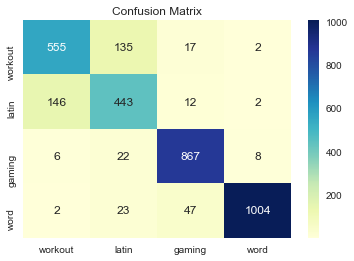

In [42]:
plot_confusion_matrix(X_train, y_train, X_test, y_test,4 )

<a id = "4.4"></a>
### Naive Bayes

In this part we use Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian. The prediction accuracy is ***`0.854`***.

In [31]:
naive_bayes(X_train, y_train, X_test, y_test)

0.854147675478578

<a id = "4.5"></a>
### Random forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In this part we use random forest classifier to predict music calssification. The prediction accuracy is ***`0.888`***, which is the highest among all five models.


In [40]:
random_forest(X_train, y_train, X_test, y_test)

0.8884837435429961

<a id = "5"></a>
# Modeling Optimization

In this section, we try to optimize our existing models so that they are able to classify more genres. We decided to add a new feature, lyrics, into the existing data sets. First, we use parameters such as artists and track name to get lyrics via musixmatch API. Then we combine lyrics into the existing data frame.
### Combine Lyrics Features with Musical Features 

In [67]:
# read Spotify data into data frame
filename = "alldata.csv" # train file name
df_data = pd.read_csv(filename, encoding="ISO-8859-1")
# get the 1st column
col_name = df_data.columns[0]
# drop the 1st column
df_data = df_data.drop(columns=col_name)

# top 20 artists and track name
df_data.head(20)[['artists', 'trackName']]

,artists,trackName
0,NOAX,The End
1,Skrillex & Kendrick Lamar,HUMBLE. - SKRILLEX REMIX
2,Onderkoffer,Beast
3,G-Eazy & A$AP Rocky & French Montana & Juicy J...,No Limit REMIX
4,Yellow Claw,DJ Turn It Up
5,Kanye West,POWER
6,Young Money & Drake,Trophies
7,Rae Sremmurd & Swae Lee & Slim Jxmmi & Juicy J,Powerglide (feat. Juicy J)
8,BlocBoy JB & Drake,Look Alive (feat. Drake)
9,Skrillex & Rick Ross,Purple Lamborghini (with Rick Ross)


In [ ]:
# retrieve lyrics data from musixmatch and add lyrics to the existing dataframe
api_key = 'REPLACE_WITH_YOUR_OAUTH_TOKEN'
df_data_lyrics = retrieve_lyrics(df_data, api_key)
# wirte new data into csv file
df_data_lyrics.to_csv('alldata_with_lyrics.csv')

In [48]:
def get_lyrics_features(data_frame):
    """
    Get the frequency of words in lyrics and drop the words with low frequency
    Args:
        data_frmae (dataframe) : data frame which contains lyrics data
    Returns: 
        (numpy ndarray) : lyrics features
    """
    
    (total_set, total_counter, song_dict, label_dict) = process_lyrics(data_frame)
    fword_list, label_dict = drop_low_freq_words(total_set, total_counter, 20, label_dict)
    features = np.zeros((data_frame.shape[0], len(fword_list)))
    idx_dict = {}
    for i in range(len(fword_list)):
        idx_dict.update({fword_list[i] : i})
    findex = 0
    for index, row in data_frame.iterrows():
        track = row['trackName']
        song_counter = song_dict[track][1]
        feature = np.zeros(len(fword_list))
        for word in fword_list:
            if word in song_counter:
                idx = idx_dict[word]
                feature[idx] = song_counter[word]
        features[findex] = feature
        findex += 1
    return features

# normalize features matrix
def normalization(features):
    features = features / features.max(axis=0)    
    return features

### Training and Testing Sets: Splitting Data (Ten Categories)

In order to preserve the percentage of samples for each genre, here we use StratifiedShuffleSplit() to split data set into training data set and test data set.

In [51]:
df = pd.read_csv("alldata_with_lyrics.csv", encoding="ISO-8859-1")
df = df.dropna(axis=0)
print('number of data',len(df.label))
lyrics_features = get_lyrics_features(df)
lyrics_features = normalization(lyrics_features)
music_features = pd.DataFrame(df, columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 
               'liveness','loudness', 'speechiness', 'valence']).values
features = np.concatenate((music_features, lyrics_features), axis=1)
y = df['label'].values
print('total number of features',len(features[0]))
X = normalization(features)
stratSplit = StratifiedShuffleSplit(y, 1, test_size=0.3)
StratifiedShuffleSplit(y, n_iter=1, test_size=0.3)
for train_idx,test_idx in stratSplit: 
    X_train=X[train_idx]
    y_train=y[train_idx]
    X_verify=X[test_idx]
    y_verify=y[test_idx]
print('number of train data',len(y_train))
print('number of test data',len(y_verify))

number of data 8222
total number of features 2261
number of train data 5755
number of test data 2467


<a id = "5.1"></a>
### SVM

In [59]:
linear_svm_predict(X_train, y_train, X_verify, y_verify)

0.5573571139035266

<a id = "5.2"></a>
### Neural Network

In [66]:
# hyperparameter
learning_rate = 0.01
RANDOM_SEED = 100

# according to the above data exploration, we here choose the most representative features
col_needed = ['acousticness', 'energy', 'danceability', 'tempo', 'valence', 'liveness']

# eliminate 'category' and 'lable'
data = df_data.loc[:, col_needed]
target = df_data.label

# get the dimensions of the matrix
N, M  = data.shape
# we add the bias term into the matrix
all_X = np.ones((N, M + 1)) 
all_X[:, 1:] = data

# one-hot encoding
num_labels = len(np.unique(target))
all_Y = np.eye(num_labels)[target.values] 

# generate train and test set
train_X, test_X, train_y, test_y = train_test_split(all_X, all_Y, test_size=0.5, random_state=RANDOM_SEED)

x_size = train_X.shape[1]   # Number of input nodes:
h_size1 = 128                # Number of hidden nodes
h_size2 = 128                # Number of hidden nodes
h_size3 = 128                # Number of hidden nodes
y_size = train_y.shape[1]  # Number of outcomes

# create arbitrary symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

# initialize arbitrary weights
w_1 = tf.Variable(tf.random_normal((x_size, h_size1), stddev = 0.01))
w_2 = tf.Variable(tf.random_normal((h_size1, h_size2), stddev = 0.01))
w_3 = tf.Variable(tf.random_normal((h_size2, y_size), stddev = 0.01))
weights = {'w_1' : w_1, 
           'w_2' : w_2,
           'w_3' : w_3}

# calculate forword propagation
# we use sigmoid function as our activation function
h1    = tf.nn.sigmoid(tf.matmul(X, weights['w_1']))  
h2    = tf.nn.sigmoid(tf.matmul(h1, weights['w_2']))
yhat  = tf.matmul(h2, weights['w_3']) 
predict = tf.argmax(yhat, axis=1)

# Backward propagation
cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
AdamOptimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# tensorflow run function
def tf_run(niter, optimizer):
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    # iteration
    for iteration in range(niter):
        sess.run(optimizer, feed_dict={X: train_X, y: train_y})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))
        if iteration % 500 == 0:
            print("iteration = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
                  % (iteration + 1, 100. * train_accuracy, 100. * test_accuracy))

    sess.close()    

# start the session
tf_run(niter=5001, optimizer=AdamOptimizer)

iteration = 1, train accuracy = 14.14%, test accuracy = 13.19%
iteration = 501, train accuracy = 42.62%, test accuracy = 42.21%
iteration = 1001, train accuracy = 46.00%, test accuracy = 45.64%
iteration = 1501, train accuracy = 49.87%, test accuracy = 45.19%
iteration = 2001, train accuracy = 53.62%, test accuracy = 44.84%
iteration = 2501, train accuracy = 57.64%, test accuracy = 42.83%
iteration = 3001, train accuracy = 61.27%, test accuracy = 41.67%
iteration = 3501, train accuracy = 66.07%, test accuracy = 41.00%
iteration = 4001, train accuracy = 68.86%, test accuracy = 39.58%
iteration = 4501, train accuracy = 72.56%, test accuracy = 38.99%
iteration = 5001, train accuracy = 74.20%, test accuracy = 39.07%


<a id = "5.3"></a>
### K-Nearest Neighbors

For K-nearest neighbors, it's already slow to use self defined matrix. Therefore, after add more features, the following function will need to run for a long time to get the result. The accuracy we get is **0.51** after optimization.

In [96]:
def mydist2 (x,y):
    dis = 0
    my_weight = [1,1,1.75,0.5,1,0.25,1,1] + (len(x)-8)*[1]
    dis = [np.square(a*b-a*c) for a,b,c in zip(my_weight,x,y)]
    distance = np.sqrt(np.sum(dis))
    return distance

knn = KNeighborsClassifier(n_neighbors=15,weights='uniform',metric=mydist2)
knn.fit(X_train, y_train) 
score_knn = knn.score(X_verify, y_verify)
print('Mean accuracy score:',score_knn)

Mean accuracy score: 0.51


<a id = "5.4"></a>
### Naive Bayes
With more features, the prediction accuracy can be improved to **`0.4008`**.

In [52]:
naive_bayes(X_train, y_train, X_verify, y_verify)

0.40089177138224563

<a id = "5.5"></a>
### Random Forest

After adding lyrics we have total 4325 features. The accuracy score improved to **0.626** with the number of trees set to be 500. To further imporve the accuracy, some important parameters can be fine tuned: the number of trees, the depth of trees and the number of features used for a split.

In [58]:
random_forest(X_train, y_train, X_verify, y_verify)

0.626266720713

Below is the confusion matrix and classification report. As you can see, **country, classical and word** has higher accuracy while **workout and gaming** still has low accuracy.

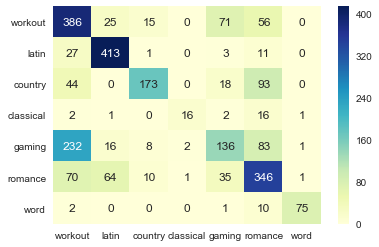

In [102]:
plot_confusion_matrix(X_train, y_train, X_verify, y_verify,7)

<a id = "6"></a>
# Summary

1. In this report, we first use boxplot to identify 4 most distinctive features. Then, we take advantage of these 4 features to build 5 machine learning models. Next, by adding lyrics feature to the data set, we successfully increased the accuracy of random forest from 54% to 63%.

2. Because of the copyright of music industry, we don't have access to all the music data such as raw audio data and lyrics. This means that there is still plenty of room for our model to improve if we can extract more representative features from raw data.

3. Certain songs inherently can be categorized into multiple genres. As a result, our model cannot accurately classify them into the correct genre. This means machine learning models are good at efficiently processing tasks which have specific, clear targets. However, when it comes to achieve tasks which are not clearly defined, machine learning models may not perform very well.

<a id = "7"></a>
# Appendix I: Data Collection

After installed and loaded the libraries, let's start collect data from 
* [Spotify Web-API](https://beta.developer.spotify.com/documentation/web-api/)
* [Musixmatch Lyrics-API](https://developer.musixmatch.com/documentation) 

### Spotify

Based on simple REST principles, the Spotify Web API endpoints return JSON metadata about music artists, albums, and tracks, directly from the Spotify Data Catalogue. The base address of Web API is https://api.spotify.com. The Web API provides a set of endpoints, each with its own unique path. This Web API also provides access to user related data. However, in this project we will simply use general data. Each endpoint requires OAuth Token which you can generate on [Spotify for Developer](https://beta.developer.spotify.com/console/get-browse-categories/) after you login to your Spotify account.

Basically, we will query the following endpoints iteratively:
- Get a List of Browse Categories (https://api.spotify.com/v1/browse/categories)
- Get a Category's playlists (https://api.spotify.com/v1/browse/categories/{category_id}/playlists)
- Get a Playlist's Tracks (https://api.spotify.com/v1/users/{user_id}/playlists/{playlist_id}/tracks)
- Get Audio Features for a Track (https://api.spotify.com/v1/audio-features/{id})

In [ ]:
# repalce it with your own API Key
api_key = 'REPLACE_WITH_YOUR_OAUTH_TOKEN'

The first step is to get all the category for playlists from Spotify. For this step we get total 38 categories.

In [2]:
def get_categories(api_key):
    """
    Return all categories of playlist.
    Args:
        api_key (string) : api key from user account
    Returns:
        (list) categories  : list of category_id
    """
    headers = {
        'Authorization': 'Bearer ' + api_key,
    }
    url = 'https://api.spotify.com/v1/browse/categories'
    url_params = {
        'limit': 50, 
        'country': 'US',
    }
    response = requests.get(url, headers=headers, params=url_params)
    data = response.json()
    items = data['categories']['items']
    categories = []
    for category in items:
        category_id = category['id']
        categories.append(category_id)
    return categories  # total 38

# replace it with your own API key here
api_key = 'REPLACE_WITH_YOUR_OAUTH_TOKEN'
category_list = get_categories(api_key)

Here is the result:

['toplists','amplify','hiphop','mood','pop',
'workout','country','latin','focus','chill',
'decades','edm_dance','rnb','rock','blackhistorymonth',
'party','sleep','inspirational','classical',
'popculture','comedy','jazz','indie_alt','gaming',
'roots','kpop','metal','romance','reggae','sessions',
'soul','punk','blues','travel','family',
'word','funk', 'iwtb', 'dinner']

After we get **category_id**, we can use it to get the playlist under this category.

In [4]:
def get_playlist(api_key, category_id):
    """
    Return urls of playlist and number of playlists under this category.
    Args:
        api_key (string) : api key from user account
        category_id (string) : category id from spotify API
    Returns:
        (urls , number) : tuple of list and dictionary. urls is the href for playlist under this category
    """
    headers = {
        'Authorization': 'Bearer ' + api_key,
    }
    url = 'https://api.spotify.com/v1/browse/categories/' + category_id +'/playlists'
    url_params = {
        'category_id': category_id,
        'limit': 50,
        'country': 'US',
    }
    response = requests.get(url, headers=headers, params=url_params)
    data = response.json()
    items = data['playlists']['items']
    urls = []
    number = {}
    for item in items:
        urls.append(item['tracks']['href'])
    number[category_id] = len(urls)
    return (urls,number) 

Since it's hard to analysis and predict based on so many categories. we select top 10 categoris according to the number of playlists.

In [7]:
import operator
number = {}
for category in category_list:
    number = {**number, **get_playlist(api_key, category)[1]}
sorted_x = sorted(number.items(), key=operator.itemgetter(1))
number = dict(sorted_x)
top_categories = list(dict(sorted_x[-10:]).keys())

```python
>>> print(top_categories)
['workout', 'country', 'latin', 'chill', 'rock', 'inspirational', 'classical', 'gaming', 'romance', 'word']
```

So, our following function will be implement based on the selected categories. With **playlist_id**, next we can get the tracts in this playlist.

In [ ]:
def get_tracts(api_key, url):
    """
    Return tracks within a category and return the dictionary of {track_id:(track_name,artists)}.
    Args:
        api_key (string): api_key from user account
        url (string) : url get from get_playlist
    Returns:
        (dictionary) track_ids : key in this dictionary is track_id and value is a tuple of track name and artists.
    """
    headers = {
        'Authorization': 'Bearer ' + api_key,
    }
    url_params = {
        'limit': 100,
        'market': 'US',
    }
    response = requests.get(url, headers=headers, params=url_params)
    data = response.json()
    items = data['items']
    track_ids = {}
    for item in items:
        artistslist = []
        if item['track'] != None:
            for a in item['track']['artists']:
                artistslist.append(a['name'])
            artists = ' & '.join(artistslist)
            track_ids[item['track']['id']] = (item['track']['name'],artists)
    return track_ids

So after we have all the **track_id**, we can get audio features for each track

In [ ]:
def get_features(api_key, track_id):
    """
    Return the feature of a track.
    Args:
        api_key (string) : api_key from user account
        track_id (string) : track id from spotify API
    Returns:
        (dictionary) data : dictionary of features returned from api
    """
    headers = {
        'Authorization': 'Bearer ' + api_key,
    }
    url = 'https://api.spotify.com/v1/audio-features/' + track_id
    response = requests.get(url, headers=headers)
    data = response.json()
    return data

Here is the sample features for a track:

```json
{
  "danceability": 0.696,
  "energy": 0.905,
  "key": 2,
  "loudness": -2.743,
  "mode": 1,
  "speechiness": 0.103,
  "acousticness": 0.011,
  "instrumentalness": 0.000905,
  "liveness": 0.302,
  "valence": 0.625,
  "tempo": 114.944,
  "type": "audio_features",
  "id": "11dFghVXANMlKmJXsNCbNl",
  "uri": "spotify:track:11dFghVXANMlKmJXsNCbNl",
  "track_href": "https://api.spotify.com/v1/tracks/11dFghVXANMlKmJXsNCbNl",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/11dFghVXANMlKmJXsNCbNl",
  "duration_ms": 207960,
  "time_signature": 4
}
```

Finally we can get all the data for the categories that we select.

In [ ]:
def get_data_of_category(api_key, category):
    """
    Return the tracks and features under this category.
    Args:
        api_key (string) : api_key from user account
        category (string) : category from spotify API
    Returns:
        (dictionary) track_features : a dictionary of dictionary, each track_id has it's corrisponding dictionary 
        of features, treakName and artists.
    """
    urls_for_tract = get_playlist(api_key, category)[0]
    tract_ids = {}
    for url in urls_for_tract:
        tract_ids = {**tract_ids, **get_tracts(api_key, url)} 
    track_features = {}
    for track_id in tract_ids.keys():
        track_features[track_id] = {}
        track_features[track_id]['features'] = get_features(api_key, track_id)
        track_features[track_id]['trackName'] = tract_ids[track_id][0]
        track_features[track_id]['artists'] = tract_ids[track_id][1]
    return track_features
all_features = {}
for category in top_categories:
    time.sleep(0.2)
    all_features[category] = get_data_of_category(api_key, category)

Now our data is in the dictionary - all_features, to **filter out the duplicate tracks** in different category and for the convenience of following process, we put the data into a **CSV** file. After drop duplication, we got total **24166** data.

In [ ]:
label = 0
result = []
for item in all_features:
    playlists = all_features[item]
    features = []
    for v in playlists.values():
        name = {}
        name['trackName'] = v['trackName']
        name['artists'] = v['artists']
        feature = {}
        feature = {**v['features'], **name}
        features.append(feature)
        df = pd.DataFrame.from_dict(features)
        cate = [item]*len(df)
        df  = df.assign(category = cate)
        l = [label]*len(df)
        df  = df.assign(label = l)
        df = df[df['analysis_url'].notnull()]
        df = df.dropna(axis=1, how='any')
        result.append(df)
#         file = item + '.csv'
#         df.to_csv(file)
    label = label + 1
alldata = pd.concat(result, ignore_index=True)
alldata = alldata.drop_duplicates(subset='id')
alldata.to_csv('alldata.csv')

### Musixmatch

In order to enrich our existing features extracted from Spotify, we decided to add a new feature, lyrics, to our data set. Musixmatch API - [matcher.lyrics.get](https://developer.musixmatch.com/documentation/api-reference/matcher-lyrics-get) is an API which let us get the lyrics of a track based on his title and artist. Based on the artists and track name we extracted from Spotify, we can get the lyrics of these songs via this API.

Also, Musixmatch API requires OAuth Token which you can generate on [Musixmatch for Developer](https://developer.musixmatch.com/) after you login to your Musixmath account.

In [ ]:
def retrieve_lyrics(data_frame, api_key):
    """
    This function is used to extract lyrics from musixmatch 
    and add lyrics to the existing dataframe
    Args:
        api_key (string) : api key from user account
        data_frame (data_frame) : data frame extracted from Spotify API
    Returns:
        (datafame) track_features : a dictionary of dictionary, each track_id has it's corrisponding dictionary 
        of features, treakName and artists.
    """
    df = data_frame.copy()
    lyrics = list()
    # retrieve lyrics from MusixMatch
    musixmatch = Musixmatch(api_key)
    for index, row in df.iterrows():
        # if lyrics is successfully retrieved from API
        content = musixmatch.matcher_lyrics_get(row['trackName'], row['artists'])
        if content['message']['header']['status_code'] == 200:
            # get the lyrics body in the message
            lyrics_body = content['message']['body']['lyrics']['lyrics_body']
            # sometimes lyrics body will be empty
        else:
            lyrics_body = ''
            
        lyrics.append(lyrics_body)
    # add lyrics data to the existing dataframe
    df['lyrics'] = lyrics
    
    return df

<a id = "8"></a>
# Appendix II: References
* Spotify Developer Documentation: https://beta.developer.spotify.com/documentation/
* Musixmatch Lyrics API Documentation: https://developer.musixmatch.com/documentation
* Support Vector Machines: http://scikit-learn.org/stable/modules/svm.html
* Neural Networks: https://www.tensorflow.org/api_docs/python/
* Naive Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
* K-Nearest Neighbours: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* Random Forest: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Confusion Matrix: https://en.wikipedia.org/wiki/Confusion_matrix